# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [27]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, DateType, DoubleType
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.sql import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from itertools import chain, combinations
import datetime
import pandas as pd
from matplotlib import pyplot as plt

In [28]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

## Load and Clean Dataset

In [29]:
df = spark.read.json("mini_sparkify_event_data.json")

In [30]:
df.count()

286500

In [31]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [32]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

Data has 286500 entries of users' activities within Sparkify with the fields as shown in the schema above.

In [33]:
df.select('userId').distinct().sort(['userId']).show(n=5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [34]:
df.filter(df['userId'].isNull()).count()

0

The `userId` field contains empty string values, but there are no NaN values.

In [35]:
df.where(df['userId'] == '').count()

8346

In [36]:
set(df.where(df['userId'] == '').select('page').collect())

{Row(page='About'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Submit Registration')}

The empty string values of user id belong most likely to users who did not signed in yet or to new users considering to register on the platform. In any case without being able to determine their identities this information does not have much value for a task at hand, so these rows can be dropped.

In [37]:
df = df.filter(df['userId'] != '')
df.count()

278154

In [38]:
df.filter(df['sessionId'].isNull()).count()

0

In [39]:
df.select('sessionId').distinct().sort(['sessionId'], ascending=False).show(n=5)

+---------+
|sessionId|
+---------+
|     2474|
|     2464|
|     2459|
|     2446|
|     2444|
+---------+
only showing top 5 rows



There are no missing or incorrect values in the `sessionId` field.

In [40]:
df.filter(df['ts'].isNull()).count()

0

In [41]:
df.select('ts').distinct().sort(['ts'], ascending=True).show(n=5)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
+-------------+
only showing top 5 rows



The timestamp field has no missing or incorrect values, but it's needed to be divided by a 1,000 in order to conform to the unix timestamp format.

## Exploratory Data Analysis

We will define `Churn` as a session where a user confirms cancellation of the service.

In [42]:
def_churn = F.udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
df = df.withColumn('churn', def_churn(df['page']))

#### Separate churning and staying users.

In [43]:
# collect all users
user_ids = list(df.select('userId').sort('userId').collect())
user_ids = set([int(list(row.asDict().values())[0]) for row in user_ids]) 
len(user_ids)

225

In [44]:
df.select('sessionId').where(df['churn']==1).count()

52

In [45]:
churn_users_rows = list(df.select('userId').where(df['churn']==1).collect())
# create a list of churned users
churn_user_ids = [int(list(row.asDict().values())[0]) for row in churn_users_rows] 

In [46]:
len(set(churn_user_ids))

52

In [47]:
print(churn_user_ids)

[18, 32, 125, 105, 17, 143, 101, 129, 121, 51, 87, 122, 12, 58, 73, 3, 106, 103, 28, 54, 29, 70, 53, 100011, 100001, 100024, 100006, 100019, 100003, 100023, 100005, 100017, 100025, 100009, 100012, 100013, 100022, 100014, 100015, 100021, 100007, 200001, 200024, 200011, 200021, 200018, 200015, 200017, 200016, 200020, 300007, 300001]


In [48]:
not_churn_users = list(user_ids - set(churn_user_ids))
print(len(not_churn_users))

173


#### Overall songs listened by a user in each category.

In [49]:
counts_churn = df[df['userId'].isin(churn_user_ids)] \
    .where(df['page'] == 'NextSong') \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .select('userId', 'count') 

Text(0,0.5,'Num of Users')

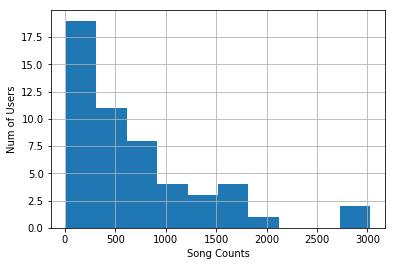

In [50]:
pd_churn_counts = counts_churn.toPandas()
pd_churn_counts.index = pd_churn_counts['userId']
pd_churn_counts['count'].hist()
plt.xlabel('Song Counts')
plt.ylabel('Num of Users')

In [51]:
counts_churn.describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|               52|               52|
|   mean|80808.42307692308|699.8846153846154|
| stddev| 86381.6770659117|714.7376497666588|
|    min|           100001|                8|
|    max|               87|             3028|
+-------+-----------------+-----------------+



In [52]:
counts_not_churn = df[df['userId'].isin(not_churn_users)] \
    .where(df['page'] == 'NextSong') \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .select('userId', 'count')

Text(0,0.5,'Num of Users')

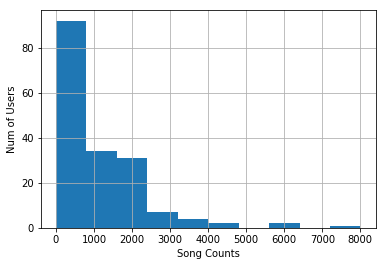

In [53]:
pd_not_churn_counts = counts_not_churn.toPandas()
pd_not_churn_counts.index = pd_not_churn_counts['userId']
pd_not_churn_counts['count'].hist()
plt.xlabel('Song Counts')
plt.ylabel('Num of Users')

In [54]:
counts_not_churn.describe().show()

+-------+------------------+------------------+
|summary|            userId|             count|
+-------+------------------+------------------+
|  count|               173|               173|
|   mean| 60756.87861271676|1108.1734104046243|
| stddev|110276.04376677402|1183.1467030410008|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



Create `date` field in the dataframe.

In [55]:
ts_to_date = F.udf(lambda ts: datetime.date.fromtimestamp(ts/1000), DateType())

In [56]:
df = df.withColumn('date', ts_to_date(df['ts']))

In [57]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, date=datetime.date(2018, 10, 1))]

In [58]:
# all the pages visited by users
pages_list = df.select('page').distinct().collect()
pages_list = [list(row.asDict().values())[0] for row in pages_list]
pages_list

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

#### Average daily page visits by a user in each category.

In [59]:
def get_daily_stat(group, page):
    """Show statistics on average daily page visits of every user
    
    Keyword arguments:
    group -- a subset of users
    page -- a page to calculate statistics on
    """
    df[df['userId'].isin(group)] \
        .select('userId', 'date', 'page') \
        .where(df['page']==page) \
        .groupBy('userId', 'date') \
        .count() \
        .select('userId', 'count') \
        .groupBy('userId') \
        .avg() \
        .select('avg(count)') \
        .describe() \
        .show()

In [60]:
# go through all pages
for page in pages_list:
    print(page)
    print('  Churn')
    get_daily_stat(churn_user_ids, page)
    print('  Not Churn')
    get_daily_stat(not_churn_users, page)

Cancel
  Churn
+-------+----------+
|summary|avg(count)|
+-------+----------+
|  count|        52|
|   mean|       1.0|
| stddev|       0.0|
|    min|       1.0|
|    max|       1.0|
+-------+----------+

  Not Churn
+-------+----------+
|summary|avg(count)|
+-------+----------+
|  count|         0|
|   mean|      null|
| stddev|      null|
|    min|      null|
|    max|      null|
+-------+----------+

Submit Downgrade
  Churn
+-------+----------+
|summary|avg(count)|
+-------+----------+
|  count|         9|
|   mean|       1.0|
| stddev|       0.0|
|    min|       1.0|
|    max|       1.0|
+-------+----------+

  Not Churn
+-------+-------------------+
|summary|         avg(count)|
+-------+-------------------+
|  count|                 40|
|   mean|              1.025|
| stddev|0.15811388300841897|
|    min|                1.0|
|    max|                2.0|
+-------+-------------------+

Thumbs Down
  Churn
+-------+------------------+
|summary|        avg(count)|
+-------+--------

#### Gender distribution of two groups

In [61]:
df[df['userId'].isin(churn_user_ids)] \
    .select('userId', 'gender') \
    .distinct() \
    .groupBy('gender') \
    .count() \
    .show()

+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+



In [62]:
df[df['userId'].isin(not_churn_users)] \
    .select('userId', 'gender') \
    .distinct() \
    .groupBy('gender') \
    .count() \
    .show()

+------+-----+
|gender|count|
+------+-----+
|     F|   84|
|     M|   89|
+------+-----+



#### Likes/Dislikes ratio for two groups.

In [63]:
tempdf_left = df[df['userId'].isin(churn_user_ids)] \
    .where((df['page']=='Thumbs Up')) \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'TU_count')

tempdf_right = df[df['userId'].isin(churn_user_ids)] \
    .where((df['page']=='Thumbs Down')) \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'TD_count')

churn_thumbs = tempdf_left.join(tempdf_right, on='userId')
churn_thumbs = churn_thumbs.withColumn('ratio', churn_thumbs['TU_count']/churn_thumbs['TD_count'])
churn_thumbs.select('ratio').describe().show()

+-------+-----------------+
|summary|            ratio|
+-------+-----------------+
|  count|               47|
|   mean|4.373827737796708|
| stddev|3.395079074337746|
|    min|              1.0|
|    max|             20.0|
+-------+-----------------+



Text(0,0.5,'Num of Users')

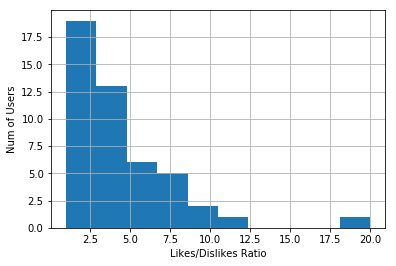

In [64]:
pd_thumbs_churn = churn_thumbs.toPandas()
pd_thumbs_churn['ratio'].hist()
plt.xlabel('Likes/Dislikes Ratio')
plt.ylabel('Num of Users')

In [65]:
tempdf_left = df[df['userId'].isin(not_churn_users)] \
    .where((df['page']=='Thumbs Up')) \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'TU_count')

tempdf_right = df[df['userId'].isin(not_churn_users)] \
    .where((df['page']=='Thumbs Down')) \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'TD_count')

not_churn_thumbs = tempdf_left.join(tempdf_right, on='userId')
not_churn_thumbs = not_churn_thumbs.withColumn('ratio', not_churn_thumbs['TU_count']/not_churn_thumbs['TD_count']) 
not_churn_thumbs.select('ratio').describe().show()

+-------+------------------+
|summary|             ratio|
+-------+------------------+
|  count|               155|
|   mean| 6.239476013176319|
| stddev|3.5359882638820803|
|    min| 1.105263157894737|
|    max|              21.0|
+-------+------------------+



Text(0,0.5,'Num of Users')

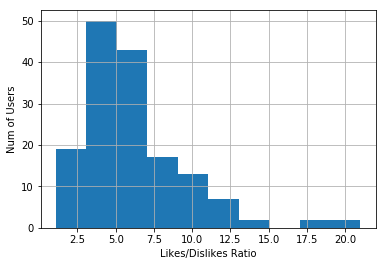

In [66]:
pd_thumbs_not_churn = not_churn_thumbs.toPandas()
pd_thumbs_not_churn['ratio'].hist()
plt.xlabel('Likes/Dislikes Ratio')
plt.ylabel('Num of Users')

#### Average number of songs per day 

In [67]:
temp_df = df[df['userId'].isin(churn_user_ids)] \
    .select('userId', 'date', 'page') \
    .where(df['page']=='NextSong') \
    .groupBy('userId', 'date') \
    .count()
temp_df.select('userId', 'count').groupBy('userId').avg().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|       avg(count)|
+-------+-----------------+-----------------+
|  count|               52|               52|
|   mean|80808.42307692308|62.53653785936774|
| stddev| 86381.6770659117|37.00991911359263|
|    min|           100001|              8.0|
|    max|               87|162.3846153846154|
+-------+-----------------+-----------------+



In [68]:
temp_df = df[df['userId'].isin(not_churn_users)] \
    .select('userId', 'date', 'page') \
    .where(df['page']=='NextSong') \
    .groupBy('userId', 'date') \
    .count()
temp_df.select('userId', 'count').groupBy('userId').avg().describe().show()

+-------+------------------+------------------+
|summary|            userId|        avg(count)|
+-------+------------------+------------------+
|  count|               173|               173|
|   mean| 60756.87861271676| 64.98898351495575|
| stddev|110276.04376677402| 30.53178020677548|
|    min|                10|               3.0|
|    max|                99|151.76470588235293|
+-------+------------------+------------------+



#### Overall number of songs by top-20 performers listened by users in each category

In [69]:
top_20 = df.filter(df['page']=='NextSong') \
    .select('artist', 'page') \
    .groupBy('artist') \
    .count() \
    .sort('count', ascending=False) \
    .select('artist') \
    .take(20)
top_20_artists = [list(row.asDict().values())[0] for row in top_20]
top_20_artists

['Kings Of Leon',
 'Coldplay',
 'Florence + The Machine',
 'Dwight Yoakam',
 'BjÃ\x83Â¶rk',
 'The Black Keys',
 'Muse',
 'Justin Bieber',
 'Jack Johnson',
 'Eminem',
 'Radiohead',
 'Alliance Ethnik',
 'Train',
 'Taylor Swift',
 'OneRepublic',
 'The Killers',
 'Linkin Park',
 'Evanescence',
 'Harmonia',
 "Guns N' Roses"]

In [70]:
temp_df = df[df['userId'].isin(churn_user_ids) & df['artist'].isin(top_20_artists)] \
    .select('userId', 'artist') \
    .groupBy('userId') \
    .count() \
    .describe() \
    .show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|               49|               49|
|   mean| 81671.3469387755|65.75510204081633|
| stddev|88183.98296165405|63.26022006108475|
|    min|           100001|                1|
|    max|               87|              260|
+-------+-----------------+-----------------+



In [71]:
temp_df = df[df['userId'].isin(not_churn_users) & df['artist'].isin(top_20_artists)] \
    .select('userId', 'artist') \
    .groupBy('userId') \
    .count() \
    .describe() \
    .show()

+-------+------------------+------------------+
|summary|            userId|             count|
+-------+------------------+------------------+
|  count|               171|               171|
|   mean| 59712.16959064327|100.98830409356725|
| stddev|109290.78313159863|105.18141125772084|
|    min|                10|                 1|
|    max|                99|               686|
+-------+------------------+------------------+



#### Daily number of songs by top-20 performers listened by users in each category

In [72]:
temp_df = df[df['userId'].isin(churn_user_ids) & df['artist'].isin(top_20_artists[:10])] \
    .select('userId', 'date', 'page') \
    .groupBy('userId', 'date') \
    .count()
temp_df.select('userId', 'count').groupBy('userId').avg().select('avg(count)').describe().show()

+-------+------------------+
|summary|        avg(count)|
+-------+------------------+
|  count|                47|
|   mean| 4.481743048126029|
| stddev|1.8621936918143176|
|    min|               1.0|
|    max|10.090909090909092|
+-------+------------------+



In [73]:
temp_df = df[df['userId'].isin(not_churn_users) & df['artist'].isin(top_20_artists[:10])] \
    .select('userId', 'date', 'page') \
    .groupBy('userId', 'date') \
    .count()
temp_df.select('userId', 'count').groupBy('userId').avg().select('avg(count)').describe().show()

+-------+-----------------+
|summary|       avg(count)|
+-------+-----------------+
|  count|              170|
|   mean|4.464588296783663|
| stddev|1.896861997303033|
|    min|              1.0|
|    max|             10.6|
+-------+-----------------+



#### Calculating average songs listened per certain page visited by a user (Error, Ads, Settings, etc.)

In [74]:
def stat_over_window(group, page):
    """Calculate statistics on average song listened between visiting a certain page
    and return summary dataframe
    
    Keyword arguments:
    group -- a subset of users
    page -- a page to calculate statistics on
    """
    function = F.udf(lambda isact : int(isact == page), IntegerType())
    
    user_window = Window \
        .partitionBy('userId') \
        .orderBy(F.desc('ts')) \
        .rangeBetween(Window.unboundedPreceding, 0)
    
    cusum = df[df['userId'].isin(group)] \
        .filter((df.page == 'NextSong') | (df.page == page)) \
        .select('userId', 'page', 'ts') \
        .withColumn('actionflag', function(F.col('page'))) \
        .withColumn('period', F.sum('actionflag').over(user_window))

    cusum = cusum.filter((cusum.page == 'NextSong')) \
        .groupBy('userId', 'period') \
        .agg({'period':'count'}) \
        .groupBy('userId') \
        .agg({'count(period)':'avg'}) \
        .withColumnRenamed('avg(count(period))', page)
    
    return cusum

In [75]:
for page in pages_list:
    print(page)
    print('  Churn')
    stat_over_window(churn_user_ids, page) \
        .select(page) \
        .describe() \
        .show()
    print('  Not Churn')
    stat_over_window(not_churn_users, page) \
        .select(page) \
        .describe() \
        .show()

Cancel
  Churn
+-------+-----------------+
|summary|           Cancel|
+-------+-----------------+
|  count|               52|
|   mean|699.8846153846154|
| stddev|714.7376497666588|
|    min|              8.0|
|    max|           3028.0|
+-------+-----------------+

  Not Churn
+-------+------------------+
|summary|            Cancel|
+-------+------------------+
|  count|               173|
|   mean|1108.1734104046243|
| stddev|1183.1467030410008|
|    min|               3.0|
|    max|            8002.0|
+-------+------------------+

Submit Downgrade
  Churn
+-------+-----------------+
|summary| Submit Downgrade|
+-------+-----------------+
|  count|               52|
|   mean|614.4615384615385|
| stddev|  657.35508241289|
|    min|              8.0|
|    max|           3028.0|
+-------+-----------------+

  Not Churn
+-------+-----------------+
|summary| Submit Downgrade|
+-------+-----------------+
|  count|              173|
|   mean|847.5963391136801|
| stddev|801.4032952476591|


Some of the above statistics but with visualizations added

+-------+------------------+
|summary|            Logout|
+-------+------------------+
|  count|                52|
|   mean|54.292091481755385|
| stddev|23.331703432626753|
|    min|               8.0|
|    max|             111.0|
+-------+------------------+



Text(0,0.5,'Num of Users')

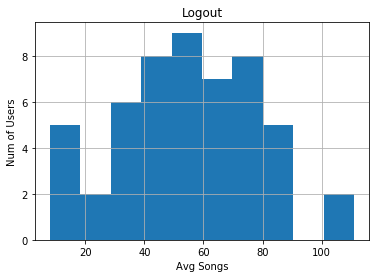

In [76]:
temp_df = stat_over_window(churn_user_ids, 'Logout').select('Logout')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|            Logout|
+-------+------------------+
|  count|               173|
|   mean| 63.91875016123472|
| stddev| 26.07710325655027|
|    min|               3.0|
|    max|136.66666666666666|
+-------+------------------+



Text(0,0.5,'Num of Users')

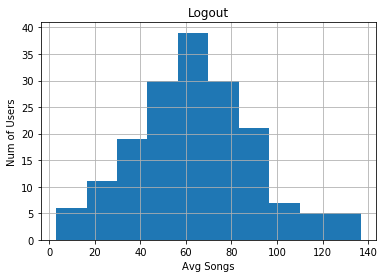

In [77]:
temp_df = stat_over_window(not_churn_users, 'Logout').select('Logout')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|       Roll Advert|
+-------+------------------+
|  count|                52|
|   mean|108.89277117483964|
| stddev| 296.9007797557819|
|    min|3.6666666666666665|
|    max|            2111.0|
+-------+------------------+



Text(0,0.5,'Num of Users')

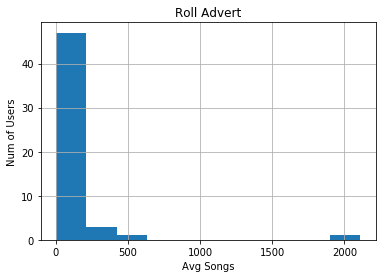

In [78]:
temp_df = stat_over_window(churn_user_ids, 'Roll Advert').select('Roll Advert')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|       Roll Advert|
+-------+------------------+
|  count|               173|
|   mean| 179.7432117101711|
| stddev|263.06293257669967|
|    min|               1.5|
|    max|            1427.0|
+-------+------------------+



Text(0,0.5,'Num of Users')

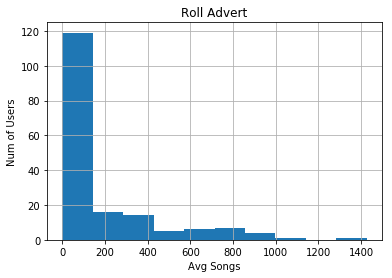

In [79]:
temp_df = stat_over_window(not_churn_users, 'Roll Advert').select('Roll Advert')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|              Help|
+-------+------------------+
|  count|                52|
|   mean|119.50251060279244|
| stddev| 61.67577524038779|
|    min|               8.0|
|    max|254.66666666666666|
+-------+------------------+



Text(0,0.5,'Num of Users')

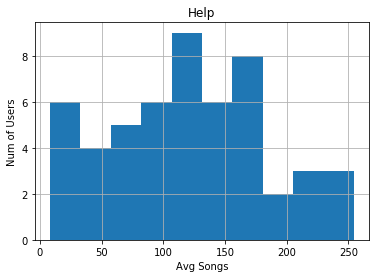

In [80]:
temp_df = stat_over_window(churn_user_ids, 'Help').select('Help')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|              Help|
+-------+------------------+
|  count|               173|
|   mean|140.59098495232584|
| stddev| 81.01392992357042|
|    min|               3.0|
|    max|             583.0|
+-------+------------------+



Text(0,0.5,'Num of Users')

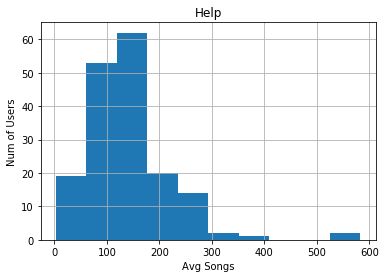

In [81]:
temp_df = stat_over_window(not_churn_users, 'Help').select('Help')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+-----------------+
|summary|            Error|
+-------+-----------------+
|  count|               52|
|   mean|450.9519230769231|
| stddev|523.8331228713437|
|    min|              8.0|
|    max|           3028.0|
+-------+-----------------+



Text(0,0.5,'Num of Users')

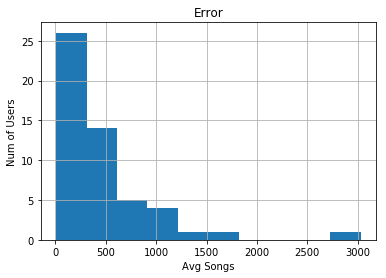

In [82]:
temp_df = stat_over_window(churn_user_ids, 'Error').select('Error')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|             Error|
+-------+------------------+
|  count|               173|
|   mean|476.35899394439866|
| stddev| 379.5928324517535|
|    min|               3.0|
|    max|            2113.0|
+-------+------------------+



Text(0,0.5,'Num of Users')

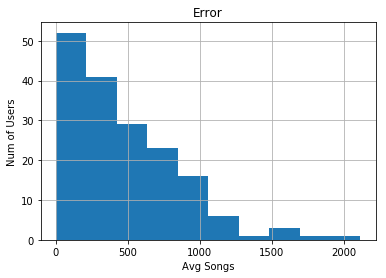

In [83]:
temp_df = stat_over_window(not_churn_users, 'Error').select('Error')
temp_df.describe().show()
temp_df.toPandas().hist()
plt.xlabel('Avg Songs')
plt.ylabel('Num of Users')

+-------+------------------+
|summary|           Upgrade|
+-------+------------------+
|  count|                52|
|   mean|268.12962454212453|
| stddev| 358.7377902534088|
|    min|               8.0|
|    max|            2111.0|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98006a1550>]], dtype=object)

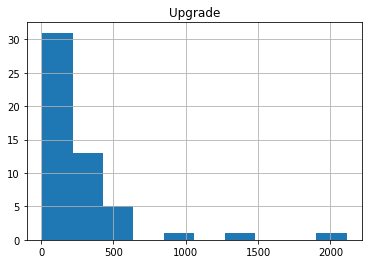

In [84]:
temp_df = stat_over_window(churn_user_ids, 'Upgrade').select('Upgrade')
temp_df.describe().show()
temp_df.toPandas().hist()

+-------+-----------------+
|summary|          Upgrade|
+-------+-----------------+
|  count|              173|
|   mean|456.6239102740549|
| stddev|576.8104885447501|
|    min|              3.0|
|    max|           4079.0|
+-------+-----------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9800593a58>]], dtype=object)

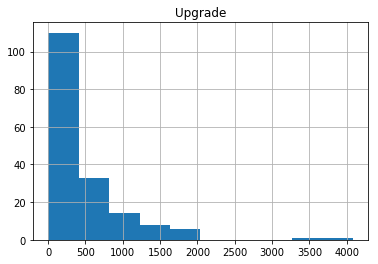

In [85]:
temp_df = stat_over_window(not_churn_users, 'Upgrade').select('Upgrade')
temp_df.describe().show()
temp_df.toPandas().hist()

# Feature Engineering  
Based on the exploratory analysis following features were chosen to build a model:
- overall number of songs per user  
- thumbs up/thumbs down ratio
- average songs listened before logging out
- average songs listened before rolling advertisment
- average songs listened before encountering an error
- average songs listened before acsessing the Help section

In [86]:
users_df = df.filter((df['userId'].isin(churn_user_ids) & (df['churn']==1)) | df['userId'].isin(not_churn_users)) \
    .select('userId', 'churn') \
    .dropDuplicates() 

In [87]:
# songs per user overall
temp_df = df.where(df['page'] == 'NextSong') \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'songsListened')

users_df = users_df.join(temp_df, on='userId')

In [88]:
# thumbs up/thumbs down ratio
tempdf_left = df.where((df['page']=='Thumbs Up')) \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'TU_count')

tempdf_right = df.where((df['page']=='Thumbs Down')) \
    .select('userId', 'page') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'TD_count')

temp_df = tempdf_left.join(tempdf_right, on='userId') 

temp_df = temp_df.withColumn('thumbsRatio', F.round(temp_df['TU_count']/temp_df['TD_count']))
users_df = users_df.join(temp_df.select('userId', 'thumbsRatio'), on='userId')

In [89]:
def df_stat_over_window(action):
    """Show statistics on average song listened between visiting a certain page
    and return summary dataframe
    
    Keyword arguments:
    group -- a subset of users
    page -- a page to calculate statistics on
    """
    function = F.udf(lambda isact : int(isact == action), IntegerType())
    
    user_window = Window \
        .partitionBy('userId') \
        .orderBy(F.desc('ts')) \
        .rangeBetween(Window.unboundedPreceding, 0)
    
    cusum = df.filter((df.page == 'NextSong') | (df.page == action)) \
        .select('userId', 'page', 'ts') \
        .withColumn('actionflag', function(F.col('page'))) \
        .withColumn('period', Fsum('actionflag').over(user_window))

    cusum = cusum.filter((cusum.page == 'NextSong')) \
        .groupBy('userId', 'period') \
        .agg({'period':'count'}) \
        .groupBy('userId') \
        .agg({'count(period)':"avg"}) \
        .withColumnRenamed('avg(count(period))', action)
        
    
    return cusum.withColumn(action, F.round(cusum[action], 2))

In [90]:
# including some statistics about actions taken/ancountered by a user 
actions = ['Logout', 'Roll Advert', 'Error', 'Help']

for action in actions:
    temp_df = stat_over_window(user_ids, action)
    temp_df = temp_df.withColumn(action, F.round(temp_df[action], 2))
    users_df = users_df.join(temp_df, on='userId')

In [91]:
users_df = users_df.withColumnRenamed('churn', 'label')
users_df.show()

+------+-----+-------------+-----------+------+-----------+------+------+
|userId|label|songsListened|thumbsRatio|Logout|Roll Advert| Error|  Help|
+------+-----+-------------+-----------+------+-----------+------+------+
|100010|    0|          275|        3.0|  55.0|        5.5| 275.0| 91.67|
|200002|    0|          387|        4.0|  64.5|      48.38| 387.0| 129.0|
|   124|    0|         4079|        4.0| 69.14|      815.8|582.71|169.96|
|    51|    1|         2111|        5.0| 84.44|     2111.0|1055.5|162.38|
|     7|    0|          150|        7.0|  37.5|       8.82|  75.0|  75.0|
|    15|    0|         1914|        6.0| 70.89|      957.0| 638.0|212.67|
|    54|    1|         2841|        6.0| 78.92|      60.45|1420.5|157.83|
|   155|    0|          820|       19.0| 54.67|      91.11| 205.0|  82.0|
|100014|    1|          257|        6.0| 64.25|      85.67| 257.0| 85.67|
|   132|    0|         1928|        6.0| 55.09|     642.67| 482.0|113.41|
|   101|    1|         1797|        5.

## Modeling

In [92]:
# superset of designed features
feats = ['songsListened', 'thumbsRatio', 'Logout', 'Roll Advert', 'Error', 'Help']
feats_list = list(chain.from_iterable(combinations(feats, r) for r in range(len(feats)+1)))
feats_list

[(),
 ('songsListened',),
 ('thumbsRatio',),
 ('Logout',),
 ('Roll Advert',),
 ('Error',),
 ('Help',),
 ('songsListened', 'thumbsRatio'),
 ('songsListened', 'Logout'),
 ('songsListened', 'Roll Advert'),
 ('songsListened', 'Error'),
 ('songsListened', 'Help'),
 ('thumbsRatio', 'Logout'),
 ('thumbsRatio', 'Roll Advert'),
 ('thumbsRatio', 'Error'),
 ('thumbsRatio', 'Help'),
 ('Logout', 'Roll Advert'),
 ('Logout', 'Error'),
 ('Logout', 'Help'),
 ('Roll Advert', 'Error'),
 ('Roll Advert', 'Help'),
 ('Error', 'Help'),
 ('songsListened', 'thumbsRatio', 'Logout'),
 ('songsListened', 'thumbsRatio', 'Roll Advert'),
 ('songsListened', 'thumbsRatio', 'Error'),
 ('songsListened', 'thumbsRatio', 'Help'),
 ('songsListened', 'Logout', 'Roll Advert'),
 ('songsListened', 'Logout', 'Error'),
 ('songsListened', 'Logout', 'Help'),
 ('songsListened', 'Roll Advert', 'Error'),
 ('songsListened', 'Roll Advert', 'Help'),
 ('songsListened', 'Error', 'Help'),
 ('thumbsRatio', 'Logout', 'Roll Advert'),
 ('thumbsRa

In [93]:
len(feats_list)

64

In [94]:
# split the dataset
(trainSet, validationSet, testSet) = users_df.randomSplit([0.7, 0.15, 0.15], seed=42)

In [95]:
minor_df = trainSet.where(users_df['label']==1)
major_df = trainSet.where(users_df['label']==0)
ratio = major_df.count()/minor_df.count()

In [96]:
# deal with imbalance by oversampling
a = range(int(ratio))
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
trainSet = major_df.unionAll(oversampled_df)
trainSet.count()

208

In [97]:
trainSet.where(users_df['label']==1).count()

93

In [98]:
trainSet.where(users_df['label']==0).count()

115

In [99]:
def create_model(feats, trainSet, validationSet):
    """Create logistic regression classifier based on trainSet.
    Tune parameters and calculate f1 metrics for validationSet.
    Return the model and corresponding f1 score.
    
    Keyword arguments:
    feats -- a collection of features to use for prediction
    trainSet -- training dataset
    validationSet -- validation dataset
    """
    # set stages for pipeline
    stages = []
    assemblerInputs = list(feats)
    print('Features: {}'.format(assemblerInputs))
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    lr = LogisticRegression(labelCol="label", featuresCol="features")
    stages += [lr]

    pipeline = Pipeline(stages=stages)
    
    # set parameter grid
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
        .addGrid(lr.maxIter, [5, 7, 10]) \
        .addGrid(lr.threshold, [0.3, 0.5, 0.7])\
        .build()

    #set crossvalidator
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3)
    
    model = crossval.fit(trainSet)
    results = model.transform(validationSet)

    # compute metrics
    eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    
    
    true_positive = results.filter((results.label==1) & (results.prediction==1)).count()
    false_positive = results.filter((results.label==0) & (results.prediction==1)).count()
    try:
        precision = true_positive / (true_positive+false_positive)
        relevant_elements = results.filter(results.label==1).count()
        recall = true_positive / relevant_elements
        f1_score = 0.5*precision + 0.5*recall
        print(f1_score)
    except:
        print("NaN")
    
    f1_score = eval_f1.evaluate(results)
    
    return model, f1_score
  

In [100]:
model, f1_score = create_model(feats_list[63], trainSet, validationSet) 

Features: ['songsListened', 'thumbsRatio', 'Logout', 'Roll Advert', 'Error', 'Help']
0.5666666666666667


In [101]:
f1_score

0.44752673796791453

In [102]:
# extract the parameters
max_iter = model.bestModel.stages[-1]._java_obj.parent().getMaxIter()
elastic_net = model.bestModel.stages[-1]._java_obj.parent().getElasticNetParam()
treshold = model.bestModel.stages[-1]._java_obj.parent().getThreshold()
print('Chosen parameters:\nmaxIter={}\nelasticNetParam={}\nthreshold={}'.format(max_iter, elastic_net, treshold))

Chosen parameters:
maxIter=10
elasticNetParam=0.0
threshold=0.3


In [103]:
# test the model
results = model.transform(testSet)
         
# compute metrics
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
print('f1score = {}'.format(eval_f1.evaluate(results)))

f1score = 0.6300533943554538
